<h2>Análise de Sentimentos e Impacto de Atrasos em Companhias Aéreas</h2>

Este projeto tem como objetivo analisar avaliações de passageiros de companhias aéreas a partir de reviews textuais em inglês, a fim de:

  - Classificar o sentimento das avaliações em positivo, neutro ou negativo com base em técnicas de processamento de linguagem natural (NLP) e aprendizado de máquina.
  - Explorar os principais temas citados nas avaliações, com foco em experiências negativas.
  - Avaliar o impacto de atrasos de voo na satisfação dos clientes, utilizando uma métrica de NPS adaptada (%positivos - %negativos) por companhia aérea.

Para isso, o projeto combina análises textuais, modelagem preditiva e comparações de NPS com e sem atrasos. A análise pode ajudar companhias aéreas a identificar pontos de melhoria na experiência do cliente.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE 
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("C:\\Users\\User\\Downloads\\Travel_Chalenge\\Travel_Chalenge.csv", sep=";")
df.head()

,Airline Name,Overall_Rating,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
0,Air Seychelles,8,Air Seychelles customer review,10th April 2011,LHR-SEZ-LHR. It's true that there aren't perso...,NaN,NaN,Economy Class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CityJet,1,CityJet customer review,10th April 2011,London City to Antwerp was delayed 3 hours 40 ...,NaN,NaN,Economy Class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Shanghai Airlines,9,Shanghai Airlines customer review,10th April 2012,PEK to HGH in Economy. Slight delay out of PEK...,NaN,NaN,Economy Class,NaN,NaN,3.0,4.0,4.0,NaN,2.0,NaN
3,Aerolineas Argentinas,8,Aerolineas Argentinas customer review,10th April 2014,Rio to Buenos Aires AEP on 737. Departure dela...,NaN,NaN,Economy Class,NaN,NaN,3.0,4.0,0.0,NaN,0.0,NaN
4,Adria Airways,7,Adria Airways customer review,10th April 2015,Outbound flight FRA/PRN A319. 2 hours 10 min f...,NaN,NaN,Economy Class,NaN,NaN,4.0,4.0,4.0,NaN,0.0,NaN


In [3]:
# Verifica quantos valores nulos existem por coluna
print(df.isnull().sum())

Airline Name                  0
Overall_Rating                0
Review_Title                  0
Review Date                   0
Review                        0
Aircraft                  12037
Type Of Traveller          1749
Seat Type                   241
Route                      1826
Date Flown                 1758
Seat Comfort               2246
Cabin Staff Service        2336
Food & Beverages           5778
Ground Service             2646
Inflight Entertainment     8471
Wifi & Connectivity       12459
dtype: int64


Todas os registros da base possuem um comentário preenchido. No entanto, há casos de notas individuais com valores nulos.

In [4]:
# Filtra duplicatas com base nas 3 colunas
duplicatas = df[df.duplicated(subset=['Review', 'Review Date', 'Airline Name'], keep=False)]

# Exibe a quantidade de duplicatas  
print(f"Total de duplicatas: {len(duplicatas)}")

# Exibe os casos encontrados
duplicatas.sort_values(by=['Review', 'Review Date', 'Airline Name']).head(10)

Total de duplicatas: 60


,Airline Name,Overall_Rating,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
13004,Alaska Airlines,1,"""Not a great airline at all""",30th January 2023,Terrible attitude from the lady at 11am at g...,Boeing 737-900,Family Leisure,Economy Class,San Francisco to Newark,January 2023,1.0,1.0,1.0,1.0,1.0,1.0
13005,Alaska Airlines,1,"""flight attendants did the bare minimum""",30th January 2023,Terrible attitude from the lady at 11am at g...,Boeing 737-900,Family Leisure,Economy Class,San Francisco to Newark,January 2023,1.0,1.0,1.0,1.0,1.0,1.0
1548,Kulula,n,Kulula customer review,12th May 2007,Cape Town to Johannesburg. Very cheap ticket w...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1549,Kulula,n,Kulula customer review,12th May 2007,Cape Town to Johannesburg. Very cheap ticket w...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14072,Luxair,n,Luxair customer review,3rd March 2007,Dub-Man-Dub. An airline which truly shows what...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14073,Luxair,n,Luxair customer review,3rd March 2007,Dub-Man-Dub. An airline which truly shows what...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2033,Luxair,n,Luxair customer review,13th March 2006,Dublin-Manchester. Missed a flight with anothe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2034,Luxair,n,Luxair customer review,13th March 2006,Dublin-Manchester. Missed a flight with anothe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8767,Kulula,n,Kulula customer review,23rd September 2006,Durban to Cape Town. Checked in 2 hours before...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8768,Kulula,n,Kulula customer review,23rd September 2006,Durban to Cape Town. Checked in 2 hours before...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Verificamos que existem casos de comentários duplicados na base, podendo variar o título da Review, mas com o mesmo conteúdo e mesmas informações de voo.

In [5]:
# Remove duplicatas mantendo apenas a primeira ocorrência
df = df.drop_duplicates(subset=['Review', 'Review Date', 'Airline Name'], keep='first')
df.head()

,Airline Name,Overall_Rating,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
0,Air Seychelles,8,Air Seychelles customer review,10th April 2011,LHR-SEZ-LHR. It's true that there aren't perso...,NaN,NaN,Economy Class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CityJet,1,CityJet customer review,10th April 2011,London City to Antwerp was delayed 3 hours 40 ...,NaN,NaN,Economy Class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Shanghai Airlines,9,Shanghai Airlines customer review,10th April 2012,PEK to HGH in Economy. Slight delay out of PEK...,NaN,NaN,Economy Class,NaN,NaN,3.0,4.0,4.0,NaN,2.0,NaN
3,Aerolineas Argentinas,8,Aerolineas Argentinas customer review,10th April 2014,Rio to Buenos Aires AEP on 737. Departure dela...,NaN,NaN,Economy Class,NaN,NaN,3.0,4.0,0.0,NaN,0.0,NaN
4,Adria Airways,7,Adria Airways customer review,10th April 2015,Outbound flight FRA/PRN A319. 2 hours 10 min f...,NaN,NaN,Economy Class,NaN,NaN,4.0,4.0,4.0,NaN,0.0,NaN


In [6]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def preprocess_text(text):
    if pd.isnull(text):
        return ""
    
    text = text.lower()    
    text = re.sub(r'[^a-záéíóúâêîôûãõç\s]', '', text)
    tokens = word_tokenize(text, language='english')
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

In [7]:
# nltk.download()

In [8]:
df['Review_clean'] = df['Review'].apply(preprocess_text)
df['Review_title_clean'] = df['Review_Title'].apply(preprocess_text)

In [9]:
df['Airline Name'].value_counts()

Airline Name
LATAM Airlines         100
Air Transat            100
Ethiopian Airlines     100
FlySafair              100
LOT Polish Airlines    100
                      ... 
BA CityFlyer            72
Lao Airlines            72
Uzbekistan Airways      72
Shanghai Airlines       72
Luxair                  69
Name: count, Length: 182, dtype: int64

In [10]:
df['Overall_Rating'].value_counts()

Overall_Rating
1    9369
2    1873
9    1293
8    1252
3    1047
7     840
4     606
5     600
6     487
n     305
Name: count, dtype: int64

Verificamos uma nota 'n', que não possui nenhum significado relevante para a análise. Será feito o tratamento desses casos com sua remoção da base:

In [11]:
df_tratado = df.copy()
df_tratado = df_tratado[df_tratado['Overall_Rating'] != 'n'].astype({'Overall_Rating': 'float'})

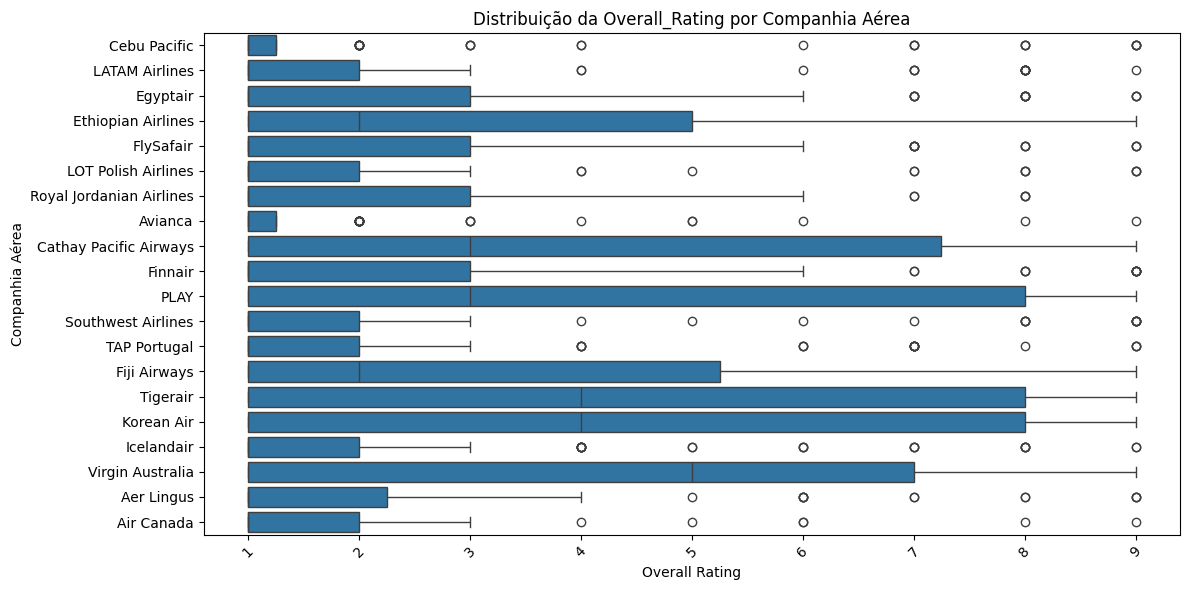

In [12]:
top_airlines = df_tratado['Airline Name'].value_counts().nlargest(20).index
df_top_airlines = df_tratado[df_tratado['Airline Name'].isin(top_airlines)]

# Distribuição por companhias aéreas
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_airlines, x="Overall_Rating", y="Airline Name", orient='h')
plt.xticks(rotation=45)
plt.title("Distribuição da Overall_Rating por Companhia Aérea")
plt.xlabel("Overall Rating")
plt.ylabel("Companhia Aérea")
plt.tight_layout()
plt.show()

Análise por algumas companhias aéreas:
- <strong>Cathay Pacific Airways:</strong> A caixa é relativamente longa, indicando uma variabilidade maior nas avaliações, mas a maioria dos passageiros parece ter uma experiência positiva, apresentando uma mediana alta.
- <strong>Korean Air:</strong> Similar à Cathay Pacific, apresenta uma mediana alta e uma boa parte das avaliações concentrada em valores elevados. A dispersão também é considerável, com alguns outliers de avaliações mais baixas.
- <strong>Virgin Australia:</strong> Possui a mediana da avaliação geral mais alta entre as companhias aéreas apresentadas no gráfico. Isso sugere que, de maneira geral, os passageiros tendem a avaliar a Virgin Australia de forma mais positiva em comparação com as outras companhias.
- <strong>Air Canada:</strong> Apresenta uma mediana mais baixa em comparação com as primeiras companhias mencionadas, e a dispersão das avaliações parece ser menor.
- <strong>Cebu Pacific:</strong> Tem a mediana da avaliação geral mais baixa dentre as companhias listadas, e a maioria das avaliações se concentra em valores baixos.

Como são muitas companhias aéreas, pode ser difícil de verificar as reviews em maior profundidade. Para isso, vamos fazer um agrupamento das companhias aéreas por região.

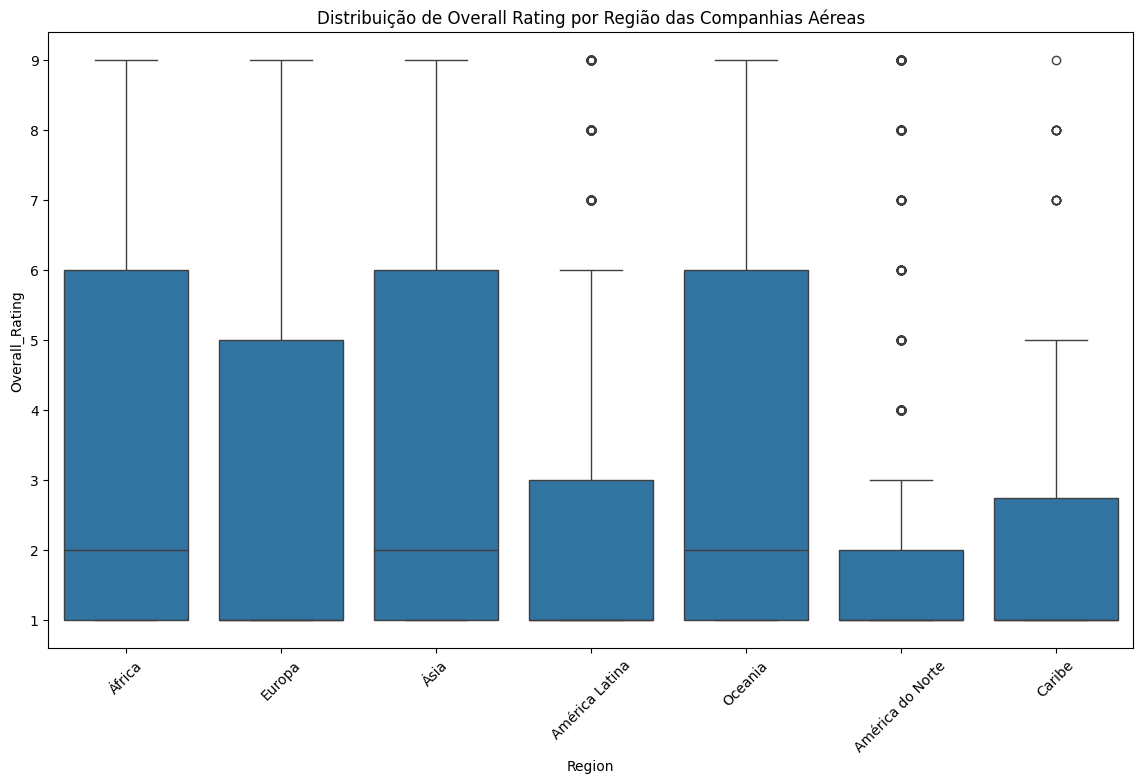

In [13]:
# Mapeando as companhias aéreas para suas respectivas regiões
region_map = {
    'Air Seychelles': 'África', 'CityJet': 'Europa', 'Shanghai Airlines': 'Ásia',
    'Aerolineas Argentinas': 'América Latina', 'Adria Airways': 'Europa', 'QantasLink': 'Oceania',
    'Cubana Airlines': 'América Latina', 'SilkAir': 'Ásia', 'Air Berlin': 'Europa', 'Monarch Airlines': 'Europa',
    'Air Malta': 'Europa', 'Air Arabia': 'Ásia', 'Air China': 'Ásia', 'Air Tahiti Nui': 'Oceania',
    'Blue Air': 'Europa', 'Edelweiss Air': 'Europa', 'Kulula': 'África', 'AirAsia Philippines': 'Ásia',
    'EVA Air': 'Ásia', 'Oman Air': 'Ásia', 'Japan Airlines': 'Ásia', 'Kenya Airways': 'África',
    'ITA Airways': 'Europa', 'Silver Airways': 'América do Norte', 'Sun Country Airlines': 'América do Norte',
    'Air France': 'Europa', 'Breeze Airways': 'América do Norte', 'British Airways': 'Europa',
    'China Airlines': 'Ásia', 'Flair Airlines': 'América do Norte', 'French Bee': 'Europa',
    'KLM Royal Dutch Airlines': 'Europa', 'Malaysia Airlines': 'Ásia', 'Nok Air': 'Ásia',
    'Porter Airlines': 'América do Norte', 'Qatar Airways': 'Ásia', 'Ryanair': 'Europa',
    'Sky Express Airlines': 'Europa', 'Turkish Airlines': 'Ásia', 'Lao Airlines': 'Ásia',
    'Olympic Air': 'Europa', 'US Airways': 'América do Norte', 'South African Airways': 'África',
    'Aeroflot Russian Airlines': 'Europa', 'AirAsia India': 'Ásia', 'CSA Czech Airlines': 'Europa',
    'Malindo Air': 'Ásia', 'SmartWings': 'Europa', 'Thai Lion Air': 'Ásia', 'Norwegian': 'Europa',
    'Transavia': 'Europa', 'VivaAerobús': 'América Latina', 'Air Serbia': 'Europa', 'Air Europa': 'Europa',
    'Austrian Airlines': 'Europa', 'SriLankan Airlines': 'Ásia', 'Thai Airways': 'Ásia',
    'Vietnam Airlines': 'Ásia', 'Xiamen Airlines': 'Ásia', 'Bulgaria Air': 'Europa', 'Dragonair': 'Ásia',
    'Hong Kong Airlines': 'Ásia', 'Thomson Airways': 'Europa', 'Bangkok Airways': 'Ásia',
    'Alitalia': 'Europa', 'Royal Brunei Airlines': 'Ásia', 'ANA All Nippon Airways': 'Ásia',
    'Jet2.com': 'Europa', 'Jetstar Asia': 'Ásia', 'Level': 'Europa', 'GoAir': 'Ásia',
    'Hainan Airlines': 'Ásia', 'China Southern Airlines': 'Ásia', 'Hawaiian Airlines': 'América do Norte',
    'Aeromexico': 'América Latina', 'Air New Zealand': 'Oceania', 'Batik Air': 'Ásia', 'Cebu Pacific': 'Ásia',
    'Jetstar Airways': 'Ásia', 'Swoop': 'América do Norte', 'Air Namibia': 'África', 'Air Mauritius': 'África',
    'TAM Airlines': 'América Latina', 'Virgin America': 'América do Norte', 'El Al Israel Airlines': 'Ásia',
    'Lion Air': 'Ásia', 'American Eagle': 'América do Norte', 'Condor Airlines': 'Europa',
    'Royal Air Maroc': 'África', 'Sunwing Airlines': 'América do Norte', 'Copa Airlines': 'América Latina',
    'LATAM Airlines': 'América Latina', 'Philippine Airlines': 'Ásia', 'SpiceJet': 'Ásia', 'Thai Smile Airways': 'Ásia',
    'Volotea': 'Europa', 'Wizz Air': 'Europa', 'Caribbean Airlines': 'América Latina', 'Uzbekistan Airways': 'Ásia',
    'LAN Airlines': 'América Latina', 'LIAT': 'América Latina', 'SATA Air Azores': 'Europa',
    'Garuda Indonesia': 'Ásia', 'Pegasus Airlines': 'Ásia', 'Tigerair Australia': 'Oceania', 'Air Transat': 'América do Norte',
    'Egyptair': 'África', 'Ethiopian Airlines': 'África', 'FlySafair': 'África', 'LOT Polish Airlines': 'Europa',
    'Royal Jordanian Airlines': 'Ásia', 'Avianca': 'América Latina', 'Cathay Pacific Airways': 'Ásia',
    'Finnair': 'Europa', 'PLAY': 'Europa', 'Southwest Airlines': 'América do Norte', 'TAP Portugal': 'Europa',
    'XL Airways France': 'Europa', 'Germanwings': 'Europa', 'Fiji Airways': 'Oceania', 'Insel Air': 'Caribe',
    'Tigerair': 'Ásia', 'Korean Air': 'Ásia', 'Air India Express': 'Ásia', 'Icelandair': 'Europa', 'Virgin Australia': 'Oceania',
    'Aer Lingus': 'Europa', 'Air Canada': 'América do Norte', 'American Airlines': 'América do Norte',
    'Brussels Airlines': 'Europa', 'Delta Air Lines': 'América do Norte', 'easyJet': 'Europa',
    'Frontier Airlines': 'América do Norte', 'Jetblue Airways': 'América do Norte', 'Lufthansa': 'Europa',
    'Lynx Air': 'América do Norte', 'Spirit Airlines': 'América do Norte', 'United Airlines': 'América do Norte',
    'Onur Air': 'Ásia', 'Thomas Cook Airlines': 'Europa', 'Firefly': 'Ásia', 'AirAsia': 'Ásia', 'Volaris': 'América Latina',
    'Air India': 'Ásia', 'Emirates': 'Ásia', 'Etihad Airways': 'Ásia', 'Scoot': 'Ásia', 'Air Dolomiti': 'Europa',
    'Jetstar Pacific': 'Ásia', 'Asiana Airlines': 'Ásia', 'Air Canada rouge': 'América do Norte', 'airBaltic': 'Europa',
    'Air Astana': 'Ásia', 'Allegiant Air': 'América do Norte', 'flydubai': 'Ásia', 'Go First': 'Ásia',
    'Regional Express': 'Oceania', 'Saudi Arabian Airlines': 'Ásia', 'Iberia': 'Europa',
    'Kuwait Airways': 'Ásia', 'Gulf Air': 'Ásia', 'Aegean Airlines': 'Europa', 'Rwandair': 'África',
    'Meridiana': 'Europa', 'Croatia Airlines': 'Europa', 'BA CityFlyer': 'Europa', 'Tunisair': 'África',
    'Jet Airways': 'Ásia', 'Vistara': 'Ásia', 'Eurowings': 'Europa', 'Vueling Airlines': 'Europa',
    'TUI Airways': 'Europa', 'China Eastern Airlines': 'Ásia', 'Alaska Airlines': 'América do Norte',
    'AirAsia X': 'Ásia', 'Interjet': 'América Latina', 'Avelo Airlines': 'América do Norte', 'Singapore Airlines': 'Ásia',
    'Qantas Airways': 'Oceania', 'Luxair': 'Europa', 'Thai AirAsia': 'Ásia', 'WOW air': 'Europa'
}

# Adicionando uma nova coluna de região ao seu dataframe com base na companhia aérea
df_tratado['Region'] = df_tratado['Airline Name'].map(region_map)

# Visualizando a distribuição de Overall_rating por região
plt.figure(figsize=(14, 8))
sns.boxplot(x='Region', y='Overall_Rating', data=df_tratado)
plt.xticks(rotation=45)
plt.title('Distribuição de Overall Rating por Região das Companhias Aéreas')
plt.show()

Com base no boxplot acima, podemos interpretar:
- <strong>Melhor Desempenho Mediano:</strong> Europa se destaca com a maior mediana de avaliação (~5).
- <strong>Pior Desempenho Mediano:</strong> América Latina, América do Norte e Caribe apresentam as medianas mais baixas (~1), indicando uma tendência geral de avaliações baixas nessas regiões.
- <strong>Maior Variabilidade:</strong> África, Ásia e Oceania mostram a maior dispersão nas avaliações (IQR mais largos), sugerindo uma mistura maior de companhias com notas baixas, médias e altas.
- <strong>Menor Variabilidade:</strong> América Latina, América do Norte e Caribe têm a menor variabilidade no corpo principal dos dados (IQR estreito), indicando que a maioria das companhias aéreas nessas regiões recebe notas consistentemente baixas.
- <strong>Outliers Significativos:</strong> A presença de muitos outliers altos na América do Norte, e também na América Latina e Caribe, sugere que, embora a maioria das companhias nessas regiões tenha avaliação baixa, existem algumas que se destacam com avaliações significativamente melhores.

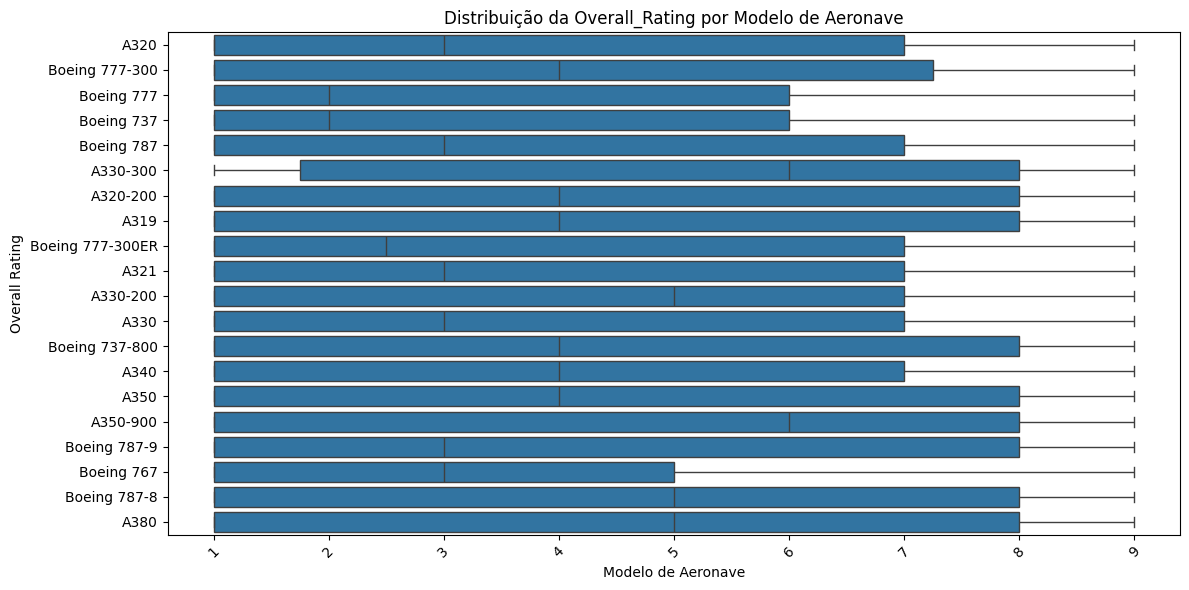

In [14]:
top_aircraft = df_tratado['Aircraft'].value_counts().nlargest(20).index
df_top_aircrafts = df_tratado[df_tratado['Aircraft'].isin(top_aircraft)]

# Distribuição por modelo de aeronave
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_aircrafts, x="Overall_Rating", y="Aircraft", orient='h')
plt.xticks(rotation=45)
plt.title("Distribuição da Overall_Rating por Modelo de Aeronave")
plt.xlabel("Modelo de Aeronave")
plt.ylabel("Overall Rating")
plt.tight_layout()
plt.show()

Podemos interpretar esses resultados da seguinte forma:
- <strong>Avaliações Positivas:</strong> Modelos como A350-900 e A330-300 parecem ter medianas mais altas, indicando que, em média, esses aviões recebem avaliações mais positivas.
- <strong>Avaliações Negativas:</strong> Boeing 777 e Boeing 737 apresentam as medianas mais baixas no conjunto.
- <strong>Grande Variabilidade Individual:</strong> Apesar das tendências medianas, a experiência do passageiro parece variar enormemente em qualquer modelo de aeronave, como indicado pela grande amplitude para quase todos os tipos. Isso sugere que outros fatores além do modelo da aeronave (companhia aérea, serviço, rota, etc.) influenciam fortemente a avaliação geral.

In [15]:
df_tratado['Food & Beverages'].unique()

array([nan,  4.,  0.,  3.,  1.,  5.,  2.])

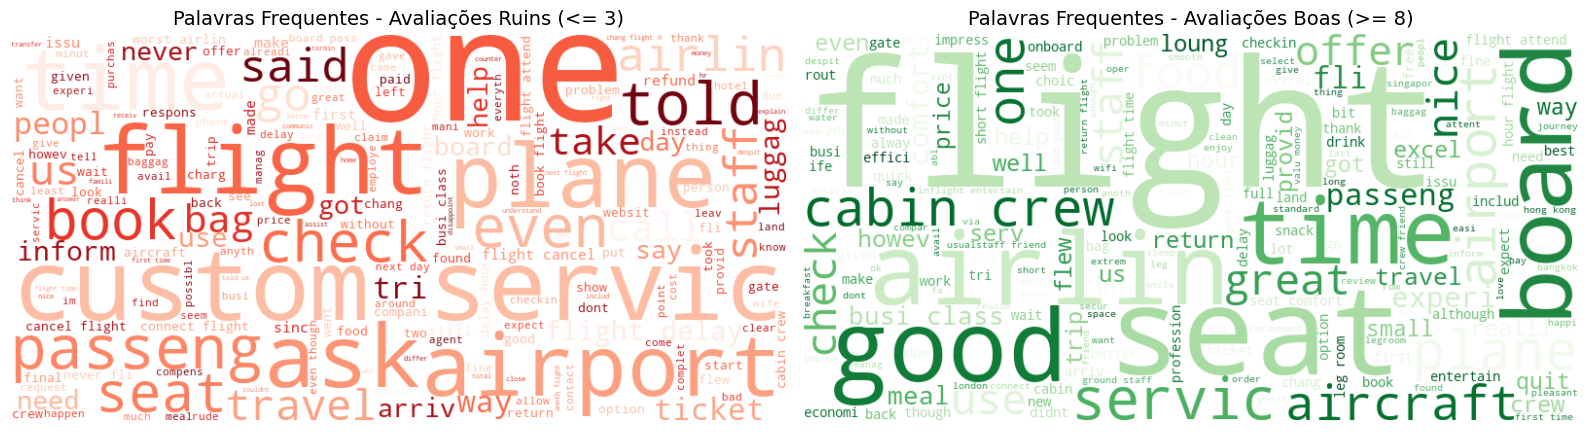

In [ ]:
# Filtra os dados
ruins = df_tratado[df_tratado['Overall_Rating'] <= 3]['Review_clean'].dropna()
boas = df_tratado[df_tratado['Overall_Rating'] >= 8]['Review_clean'].dropna()

# Junta os textos em uma única string
texto_ruins = " ".join(ruins)
texto_boas = " ".join(boas)

# Palavras a serem ignoradas (stopwords)
stopwords = set(STOPWORDS)

# Cria a nuvem de palavras para reviews ruins
wordcloud_ruins = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stopwords,
    colormap='Reds'
).generate(texto_ruins)

# Cria a nuvem de palavras para reviews boas
wordcloud_boas = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stopwords,
    colormap='Greens'
).generate(texto_boas)

# Mostra as duas nuvens lado a lado
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_ruins, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras Frequentes - Avaliações Ruins (<= 3)', fontsize=14)

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_boas, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras Frequentes - Avaliações Boas (>= 8)', fontsize=14)

plt.tight_layout()
plt.show()

Com base nas nuvens de palavras acima, podemos tirar as seguintes interpretações:
- <strong>Avaliações Ruins (<= 3):</strong>
  - As palavras mais frequentes nesta nuvem, representadas em tamanhos maiores e cores mais intensas (vermelho/laranja), indicam os principais pontos de insatisfação dos passageiros.
  - Termos como "flight", "time", "service", "airport", "customer", "book", "ticket", "delay", "cancel" e "luggage" aparecem com destaque.
  - Isso sugere que as avaliações ruins frequentemente mencionam problemas relacionados a:
    - O voo em si: atrasos ("delay"), cancelamentos ("cancel"), problemas no processo de reserva ("book", "ticket").
    - O serviço ao cliente: experiências negativas com o "service" ou "customer" support.
    - A experiência no aeroporto: questões ligadas ao "airport".
    - Tempo: problemas relacionados ao "time", que pode se referir a atrasos, tempo de espera, etc.
    - Bagagem: extravio ou problemas com a "luggage".

- <strong>Avaliações Boas (>= 8):</strong>
    - Nesta nuvem, as palavras maiores e em tons de verde indicam os aspectos positivos mais mencionados pelos passageiros.
    - Palavras como "flight", "seat", "cabin", "crew", "service", "airline", "time", "good", "comfort", "great", "board" e "check" são proeminentes.
    - Isso indica que as avaliações boas frequentemente destacam:
        - O voo e a companhia aérea: a experiência geral do "flight" e da "airline" foi positiva.
        - Conforto: o "seat" e o "comfort" a bordo foram satisfatórios.
        - Atendimento/Equipe: a "cabin crew" e o "service" prestado pela equipe foram bem avaliados.
        - Pontualidade: o "time" pode aparecer aqui em um contexto positivo, indicando pontualidade ou eficiência.
        - Processos: "board" e "check" podem indicar processos de embarque e check-in tranquilos.
        - Qualidade geral: termos como "good" e "great" reforçam a experiência positiva.

- Interpretação Geral:
  - A comparação das duas nuvens de palavras revela um contraste claro nos temas abordados em avaliações positivas e negativas. Enquanto as avaliações ruins se concentram em falhas operacionais (atrasos, cancelamentos, problemas com bagagem) e deficiências no atendimento ao cliente, as avaliações boas enfatizam o conforto a bordo, a qualidade do serviço da tripulação e, em alguns casos, a eficiência dos processos.
  - Essa análise visual permite identificar rapidamente os principais drivers de satisfação e insatisfação dos passageiros em relação às companhias aéreas avaliadas.

In [17]:
import nltk
from nltk.text import Text
tokens = nltk.word_tokenize(texto_ruins.lower())
text_nltk = Text(tokens)

# Ver contexto da palavra 'custom'
text_nltk.concordance('custom')

Displaying 25 of 5499 matches:
ort said ask reimburs paid use call custom servic mani time everi time said ta
eon call gave promis one call worst custom servic ever employe rude dont tri f
de dont tri fix mistak give respect custom never seen custom servic world fran
stak give respect custom never seen custom servic world frankfurt bangkok via 
airlin cap lost baggag unravel even custom servic complet nonexist dont answer
unreli book recent oblig cancel bad custom servic rude ladi line apolog told c
light onlin im abl checkin onlin go custom servic agent hundr peopl line wait 
te gate charlott miss connect stand custom servic line minut reach halfway poi
ut reach halfway point avail comput custom servic ever use max repres seem coo
coordin two ever avail alreadi call custom servic tri expedit time line help r
reschedul flight hotel worst exampl custom servic ever experienc everi interac
e els help look like compani doesnt custom servic ask talk supervisor look lik
sharjah sohag bad exp

In [18]:
# Definir as colunas de interesse
colunas_notas_individuais = [
    'Seat Comfort',
    'Cabin Staff Service',
    'Food & Beverages',
    'Ground Service',
    'Inflight Entertainment',
    'Wifi & Connectivity'
]
coluna_nota_final = 'Overall_Rating'

# Selecionar apenas as colunas relevantes para a análise
colunas_para_correlacao = colunas_notas_individuais + [coluna_nota_final]
df_correlacao = df_tratado[colunas_para_correlacao]

# Calcular a matriz de correlação por pearson
matriz_correlacao = df_correlacao.corr()

# Extrair as correlações com a nota final
correlacoes_com_overall = matriz_correlacao[coluna_nota_final].drop(coluna_nota_final)

print("\nCorrelação entre as notas individuais e a Nota Final (Overall_Rating):")
print(correlacoes_com_overall.sort_values(ascending=False)) # Ordena para ver o impacto do maior para o menor


Correlação entre as notas individuais e a Nota Final (Overall_Rating):
Ground Service            0.554112
Cabin Staff Service       0.504717
Seat Comfort              0.472889
Food & Beverages          0.426890
Wifi & Connectivity       0.368276
Inflight Entertainment    0.318757
Name: Overall_Rating, dtype: float64


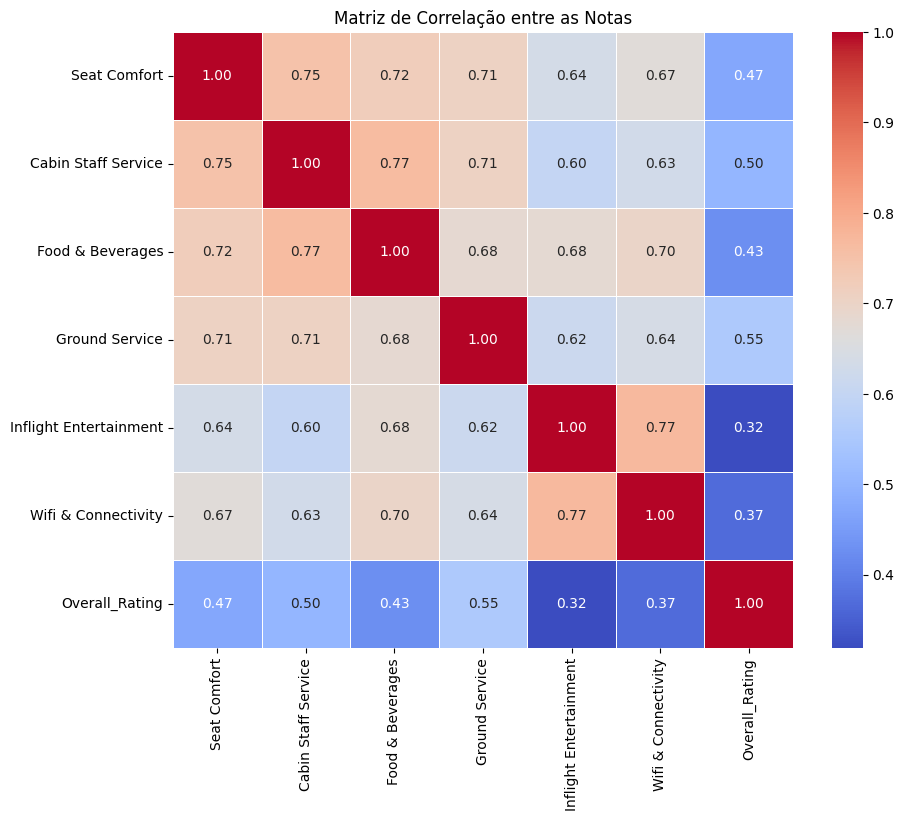

In [19]:
# --- Opcional: Visualização da matriz de correlação ---
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação entre as Notas')
plt.show()

- Análise das Correlações com Overall_Rating:
  - Cabin Staff Service (0.50): Apresenta uma correlação positiva moderada com a Overall_Rating. Isso sugere que um bom serviço da equipe de cabine está razoavelmente associado a uma maior satisfação geral.
  - Ground Service (0.55): Tem uma correlação positiva moderada com a Overall_Rating, ligeiramente mais forte que o serviço de bordo. Indica que a experiência em terra (check-in, embarque, etc.) também tem um impacto considerável na nota final.
  - Seat Comfort (0.47): Mostra uma correlação positiva moderada com a Overall_Rating. O conforto do assento contribui para a satisfação geral, mas talvez um pouco menos do que o serviço da equipe ou em terra.
  - Food & Beverages (0.43): Tem uma correlação positiva um pouco menor com a Overall_Rating em comparação com serviço de bordo e em terra, e conforto do assento. A qualidade da comida e bebida parece ter um impacto moderado na satisfação geral.
  - Wifi & Connectivity (0.37): Apresenta uma correlação positiva fraca a moderada com a Overall_Rating. A disponibilidade e qualidade do Wi-Fi e conectividade parecem ter um impacto menor na nota final do que a maioria dos outros fatores.
  - Inflight Entertainment (0.32): Mostra a correlação positiva mais fraca com a Overall_Rating entre as categorias listadas. O entretenimento a bordo parece ser o fator com menor impacto linear na satisfação geral do passageiro.

- Correlações entre notas individuais:
  - Cabin Staff Service e Food & Beverages têm uma correlação de 0.77, o que é uma correlação positiva forte. Isso pode indicar que companhias aéreas que se destacam em um desses aspectos frequentemente também se destacam no outro, ou que a percepção positiva de um influencia a percepção positiva do outro.
  - Inflight Entertainment e Wifi & Connectivity têm uma correlação de 0.77, o que também é uma correlação forte. Faz sentido que as companhias aéreas que investem em entretenimento a bordo também invistam em conectividade.

## Modelos

Primeiramente, vamos criar um modelo de classificação de sentimentos usando as colunas Review e Review_title. Esse modelo vai utilizar técnicas de Processamento de Linguagem Natural (NLP) com TF-IDF para transformar texto em números e um modelo de Machine Learning (Random Forest) para fazer as previsões.

In [20]:
# Criar uma coluna combinada de texto
df_tratado["text_combined"] = df_tratado["Review_clean"] + " " + df_tratado["Review_title_clean"]

# Definir os rótulos de sentimento
# Ajuste conforme necessário, por exemplo, com base na nota média do review
df_tratado["sentiment"] = df_tratado["Overall_Rating"].apply(lambda x: "positive" if x >= 7 else "negative" if x <= 4 else "neutral")

# Separação dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(df_tratado["text_combined"], df_tratado["sentiment"], test_size=0.2, random_state=42)

# Criando pipeline com TF-IDF e modelo Random Forest
pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english', max_features=5000),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

# Treinando o modelo
pipeline.fit(X_train, y_train)

# Fazer previsões
y_pred = pipeline.predict(X_test)

# Avaliação do modelo
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.7841105354058722
Relatório de classificação:
               precision    recall  f1-score   support

    negative       0.80      0.96      0.87      2551
     neutral       1.00      0.00      0.01       231
    positive       0.65      0.41      0.50       692

    accuracy                           0.78      3474
   macro avg       0.82      0.46      0.46      3474
weighted avg       0.79      0.78      0.74      3474



- Acurácia geral: 78% é uma boa precisão inicial, mas pode ser melhorada dependendo dos ajustes nos parâmetros e na representação dos dados.
- Classe "Negative" bem definida:
  - Precision de 80%: Quando o modelo prevê uma review negativa, ele geralmente está correto.
  - Recall de 96%: Ele está capturando quase todas as reviews negativas corretamente.
- Classe "Neutral" com baixa performance:
  - Recall de 0%: O modelo não está reconhecendo corretamente as reviews neutras.
  - Isso pode indicar um desequilíbrio nos dados, onde há poucas reviews neutras, dificultando o aprendizado do modelo.
- Classe "Positive" pode ser melhorada:
  - Recall de 41%: O modelo perde muitos exemplos positivos.
  - Precision de 65%: Ele acerta quando prevê positivo, mas poderia melhorar a captura desses casos.

Com base nos resultados, podemos identificar um desbalanceamento na base de dados. Para isso, vamos verificar se realmente é o caso:

In [21]:
df_tratado["sentiment"].value_counts()

sentiment
negative    12895
positive     3385
neutral      1087
Name: count, dtype: int64

Vemos que a classe predominante na base é a negative, o que pode afetar a performance do modelo, pois ele pode acabar favorecendo a classe majoritária. Como uma forma de balanceamento, vamos realizar um oversampling dos dados utilizando a técnica SMOTE para criar os dados sintéticos.

In [22]:
# Separar features e target
X = df_tratado["text_combined"]  # Aqui usamos os textos como entrada
y = df_tratado["sentiment"]  # Rótulo de sentimento

# Aplicar TF-IDF (transformar texto em números)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Aplicar SMOTE (Oversampling das classes minoritárias)
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Mostrar distribuição após balanceamento
print("Distribuição após SMOTE:", y_resampled.value_counts())

Distribuição após SMOTE: sentiment
positive    12895
negative    12895
neutral     12895
Name: count, dtype: int64


In [23]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Criando e treinando o modelo com os dados corretos
pipeline = RandomForestClassifier(n_estimators=100, random_state=42)
pipeline.fit(X_train, y_train)

# Fazer previsões
y_pred = pipeline.predict(X_test)
modelo1 = classification_report(y_test, y_pred)

# Exibir métricas
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Relatório de classificação:\n", modelo1)

Acurácia: 0.9413209254232907
Relatório de classificação:
               precision    recall  f1-score   support

    negative       0.94      0.88      0.91      2575
     neutral       0.99      0.98      0.98      2586
    positive       0.90      0.96      0.93      2576

    accuracy                           0.94      7737
   macro avg       0.94      0.94      0.94      7737
weighted avg       0.94      0.94      0.94      7737



- Acurácia geral: 94% é ótima taxa, indicando que o modelo está funcionando muito bem após o balanceamento das classes
- Alta precisão para todas as classes
  - O modelo está identificando corretamente os sentimentos das reviews.
  - A classe "neutral" melhorou significativamente após o balanceamento (precision de 99% e recall de 98%).
- Classe "positive" bem definida
  - Recall de 96% indica que o modelo está capturando a maioria das avaliações positivas corretamente.
  - Precision de 90% mostra que poucas previsões positivas são erradas.
- Classe "negative" mantém bom desempenho
  - Embora o recall seja um pouco menor (88%), ainda está dentro de uma faixa forte para previsões.

- Acurácia geral: 94% é ótima taxa, indicando que o modelo está funcionando muito bem após o balanceamento das classes
- Alta precisão para todas as classes
  - O modelo está identificando corretamente os sentimentos das reviews.
  - A classe "neutral" melhorou significativamente após o balanceamento (precision de 99% e recall de 98%).
- Classe "positive" bem definida
  - Recall de 96% indica que o modelo está capturando a maioria das avaliações positivas corretamente.
  - Precision de 90% mostra que poucas previsões positivas são erradas.
- Classe "negative" mantém bom desempenho
  - Embora o recall seja um pouco menor (88%), ainda está dentro de uma faixa forte para previsões.

In [24]:
# Testando uma nova review individual
nova_review = ["The flight was smooth, the staff was friendly, and the seats were comfortable. Food quality was decent, and boarding was efficient. Overall, a good experience!"]
nova_review_tfidf = vectorizer.transform(nova_review)
predicao = pipeline.predict(nova_review_tfidf)

print("Sentimento previsto para a nova review:", predicao[0])

Sentimento previsto para a nova review: positive


In [25]:
# Testando uma nova review individual
nova_review = ["The flight was awful, the staff was rude, and the seats were cramped. Food was terrible, and boarding was chaotic. Overall, a bad experience!"]
nova_review_tfidf = vectorizer.transform(nova_review)
predicao = pipeline.predict(nova_review_tfidf)

print("Sentimento previsto para a nova review:", predicao[0])

Sentimento previsto para a nova review: negative


Agora, vamos criar um modelo que seja treinado utilizando as notas das features separadas. Como visto anteriormente, tais colunas possuem valores vazios, então para realizar o treinamento do modelo, vamos considerar apenas os reviews que possuam suas colunas de notas preenchidas.

In [26]:
features = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
            'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity']
df_model = df_tratado.dropna(subset=features+['Overall_Rating']).copy()

# Separação de X e y
X = df_model[features]
y = df_model['sentiment']

# Treinamento do modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Avaliação
y_pred = clf.predict(X_test)

# Exibir métricas
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.8626834381551363
Relatório de classificação:
               precision    recall  f1-score   support

    negative       0.91      0.94      0.93       788
     neutral       0.27      0.12      0.16        51
    positive       0.63      0.64      0.64       115

    accuracy                           0.86       954
   macro avg       0.60      0.57      0.58       954
weighted avg       0.84      0.86      0.85       954



- Acurácia geral: 86% é uma boa precisão inicial, mas pode ser melhorada dependendo dos ajustes nos parâmetros e na representação dos dados.
- Classe "Negative" bem definida:
  - A precisão e recall acima de 90% indicam que o modelo está identificando corretamente avaliações negativas.
- Classe "Neutral" com baixa performance:
  - Recall de 12% indica que poucas avaliações neutras estão sendo reconhecidas corretamente.
  - Precision de 27% sugere que muitas previsões para "neutral" podem estar erradas.
- Classe "Positive" pode ser melhorada:
  - Com um recall de 64%, o modelo está capturando uma quantidade razoável de avaliações positivas.

Vamos aplicar uma técnica de oversampling para obtermos um balanceamento dos dados:

In [27]:
# Separar features e target
X = df_model["text_combined"]  # Aqui usamos os textos como entrada
y = df_model["sentiment"]  # Rótulo de sentimento

# Aplicar TF-IDF (transformar texto em números)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Aplicar SMOTE (Oversampling das classes minoritárias)
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Mostrar distribuição após balanceamento
print("Distribuição após SMOTE:", y_resampled.value_counts())

Distribuição após SMOTE: sentiment
negative    4008
neutral     4008
positive    4008
Name: count, dtype: int64


In [28]:
X_resampled

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 843968 stored elements and shape (12024, 5000)>

In [29]:
# features = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
#             'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity']
# df_model = df_tratado.dropna(subset=features+['Overall_Rating']).copy()

# # Separação de X e y
# X = df_model[features]
# y = df_model['sentiment']

# Treinamento do modelo
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Avaliação
y_pred = clf.predict(X_test)
modelo2 = classification_report(y_test, y_pred)

# Exibir métricas
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Relatório de classificação:\n", modelo2)

Acurácia: 0.9771309771309772
Relatório de classificação:
               precision    recall  f1-score   support

    negative       0.97      0.96      0.97       796
     neutral       1.00      0.99      0.99       810
    positive       0.96      0.98      0.97       799

    accuracy                           0.98      2405
   macro avg       0.98      0.98      0.98      2405
weighted avg       0.98      0.98      0.98      2405



- Acurácia geral: 97% é ótima taxa, indicando que o modelo está funcionando muito bem após o balanceamento das classes
- Classe "neutral" agora está muito bem definida  
  - Com precision e recall de quase 100%, parece que os ajustes no balanceamento e definição de classes realmente fizeram diferença.  - A classe "neutral" melhorou significativamente após o balanceamento (precision de 100% e recall de 99%).
- Classes "negative" e "positive" também estão muito fortes
  - Ambas com recall acima de 96%, indicando que o modelo está identificando corretamente as avaliações extremas.

In [30]:
def parse_report_with_accuracy(report: str) -> pd.DataFrame:
    lines = report.strip().split("\n")
    rows = []
    for line in lines[2:]:
        parts = re.split(r"\s{2,}", line.strip())
        if "accuracy" in line:
            accuracy = float(parts[1])
            rows.append(["accuracy", accuracy, accuracy, accuracy])
        elif len(parts) >= 4:
            label = parts[0]
            values = parts[1:4]
            rows.append([label] + list(map(float, values)))
    return pd.DataFrame(rows, columns=["Label", "Precision", "Recall", "F1-Score"]).set_index("Label")

# Cria os dataframes
df1 = parse_report_with_accuracy(modelo1)
df2 = parse_report_with_accuracy(modelo2)

# Junta lado a lado
comparativo = df1.join(df2, lsuffix='_Modelo1', rsuffix='_Modelo2')

# Adiciona uma coluna separadora visual
comparativo.insert(3, '---', '|')

# Exibe
comparativo

,Precision_Modelo1,Recall_Modelo1,F1-Score_Modelo1,---,Precision_Modelo2,Recall_Modelo2,F1-Score_Modelo2
Label,,,,,,,
negative,0.94,0.88,0.91,|,0.97,0.96,0.97
neutral,0.99,0.98,0.98,|,1.00,0.99,0.99
positive,0.90,0.96,0.93,|,0.96,0.98,0.97
accuracy,0.94,0.94,0.94,|,0.98,0.98,0.98
macro avg,0.94,0.94,0.94,|,0.98,0.98,0.98
weighted avg,0.94,0.94,0.94,|,0.98,0.98,0.98


- Modelo 2 tem melhor desempenho geral: A acurácia aumentou de 94% para 98%, indicando que ele está classificando os sentimentos com mais precisão. 
- Melhoria no recall das classes "negative" e "positive": O modelo 2 captura melhor as avaliações negativas e positivas. 
- Classe "neutral" manteve alta precisão: Agora com recall 99%, o modelo parece distinguir muito bem avaliações neutras.

- Modelo 1 pode ser mais útil se aceitar um pouco mais de erro e quiser um modelo que seja menos ajustado (menos overfitting).
- Modelo 2 é ideal quando alta precisão é essencial, mas pode ser interessante testar com novos dados para garantir que ele não esteja apenas memorizando padrões.

In [31]:
df_tratado['Airline Name'].unique()

array(['Air Seychelles', 'CityJet', 'Shanghai Airlines',
       'Aerolineas Argentinas', 'Adria Airways', 'QantasLink',
       'Cubana Airlines', 'SilkAir', 'Air Berlin', 'Monarch Airlines',
       'Air Malta', 'Air Arabia', 'Air China', 'Air Tahiti Nui',
       'Blue Air', 'Edelweiss Air', 'Kulula', 'AirAsia Philippines',
       'EVA Air', 'Oman Air', 'Japan Airlines', 'Kenya Airways',
       'ITA Airways', 'Silver Airways', 'Sun Country Airlines',
       'Air France', 'Breeze Airways', 'British Airways',
       'China Airlines', 'Flair Airlines', 'French Bee',
       'KLM Royal Dutch Airlines', 'Malaysia Airlines', 'Nok Air',
       'Porter Airlines', 'Qatar Airways', 'Ryanair',
       'Sky Express Airlines', 'Turkish Airlines', 'Lao Airlines',
       'Olympic Air', 'US Airways', 'South African Airways',
       'Aeroflot Russian Airlines', 'AirAsia India', 'CSA Czech Airlines',
       'Malindo Air', 'SmartWings', 'Thai Lion Air', 'Norwegian',
       'Transavia', 'VivaAerobús', 'Air S

In [32]:
# Filtrar para as 3 companhias aéreas
companhias_selecionadas = ['Qantas Airways', 'Delta Air Lines', 'Turkish Airlines']

# Filtrando o dataset
df_companhias = df_tratado[df_tratado['Airline Name'].isin(companhias_selecionadas)]
df_companhias

,Airline Name,Overall_Rating,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,...,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Review_clean,Review_title_clean,Region,text_combined,sentiment
41,Turkish Airlines,1.0,"""seats with no extra leg room""",10th April 2023,After booking and paying extra charges for mo...,NaN,Couple Leisure,Economy Class,Düsseldorf to Istanbul,April 2023,...,3.0,2.0,1.0,NaN,NaN,book pay extra charg leg room seat alloc went ...,seat extra leg room,Ásia,book pay extra charg leg room seat alloc went ...,negative
142,Turkish Airlines,3.0,"""experience has decreased drastically""",10th February 2023,I had in the past lots of good experiences. I...,NaN,Family Leisure,Economy Class,Dusseldorf to Istanbul,February 2023,...,3.0,2.0,1.0,NaN,NaN,past lot good experi like airlin promot unfort...,experi decreas drastic,Ásia,past lot good experi like airlin promot unfort...,negative
252,Delta Air Lines,1.0,"""could not have been kinder""",10th July 2023,I cannot thank the team on my Delta flight e...,NaN,Family Leisure,Economy Class,New York to Edinburgh,July 2023,...,5.0,3.0,5.0,5.0,4.0,thank team delta flight enough fli new york ed...,could kinder,América do Norte,thank team delta flight enough fli new york ed...,negative
335,Delta Air Lines,1.0,"""ridiculous amount of compensation""",10th June 2023,We had a layover in SLC on our trip from Den...,NaN,Family Leisure,Economy Class,Denver to Honolulu via Salt Lake City,March 2023,...,2.0,1.0,2.0,2.0,1.0,layov slc trip denver honolulu slc flight repe...,ridicul amount compens,América do Norte,layov slc trip denver honolulu slc flight repe...,negative
425,Delta Air Lines,4.0,"""The second bag is still in Naples""",10th May 2023,My wife and I were returning from a long del...,Boeing 767,Couple Leisure,Business Class,Naples to Atlanta via Paris,May 2023,...,5.0,4.0,1.0,5.0,4.0,wife return long delay vacat splurg first clas...,second bag still napl,América do Norte,wife return long delay vacat splurg first clas...,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17311,Qantas Airways,1.0,"""one of the worst flights""",9th February 2023,"It was one of the worst flights I ever had, ...",NaN,Couple Leisure,Economy Class,Melbourne to Manila,February 2023,...,1.0,1.0,1.0,1.0,1.0,one worst flight ever hour delay without expla...,one worst flight,Oceania,one worst flight ever hour delay without expla...,negative
17383,Turkish Airlines,1.0,"""I tried to get compensation""",9th January 2023,My outbound flight was delayed by a couple o...,NaN,Solo Leisure,Economy Class,Manchester to Kayseri via Istanbul,December 2022,...,3.0,3.0,1.0,3.0,1.0,outbound flight delay coupl hour manchest miss...,tri get compens,Ásia,outbound flight delay coupl hour manchest miss...,negative
17425,Delta Air Lines,1.0,"""Terrible experience""",9th July 2023,Terrible experience! My flight is delayed mor...,NaN,Family Leisure,Economy Class,New York JFK to Denver,July 2023,...,1.0,1.0,1.0,1.0,1.0,terribl experi flight delay hour got complimen...,terribl experi,América do Norte,terribl experi flight delay hour got complimen...,negative
17426,Delta Air Lines,3.0,"""Terrible experience with Delta""",9th July 2023,Terrible experience with Delta. I will try t...,NaN,Couple Leisure,Premium Economy,Atlanta to Santiago,July 2023,...,2.0,2.0,1.0,1.0,NaN,terribl experi delta tri avoid fli flight grou...,terribl experi delta,América do Norte,terribl experi delta tri avoid fli flight grou...,negative


Utilizando o modelo de classificação de sentimentos que já foi treinado, podemos predizer os sentimentos para as reviews filtradas:

In [33]:
# Primeiro, aplique o vetorizer em df_companhias da mesma forma que foi feito com o treinamento.
X_companhias_tfidf = vectorizer.transform(df_companhias["text_combined"])

# Agora, o modelo pode fazer previsões com a mesma quantidade de características
df_companhias['Sentiment_predict'] = clf.predict(X_companhias_tfidf)
df_companhias.reset_index(inplace=True,drop=True)

# Verificar o resultado da classificação
df_companhias[['Airline Name', 'Sentiment_predict', *features]].head()
df_companhias

,Airline Name,Overall_Rating,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,...,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Review_clean,Review_title_clean,Region,text_combined,sentiment,Sentiment_predict
0,Turkish Airlines,1.0,"""seats with no extra leg room""",10th April 2023,After booking and paying extra charges for mo...,NaN,Couple Leisure,Economy Class,Düsseldorf to Istanbul,April 2023,...,2.0,1.0,NaN,NaN,book pay extra charg leg room seat alloc went ...,seat extra leg room,Ásia,book pay extra charg leg room seat alloc went ...,negative,negative
1,Turkish Airlines,3.0,"""experience has decreased drastically""",10th February 2023,I had in the past lots of good experiences. I...,NaN,Family Leisure,Economy Class,Dusseldorf to Istanbul,February 2023,...,2.0,1.0,NaN,NaN,past lot good experi like airlin promot unfort...,experi decreas drastic,Ásia,past lot good experi like airlin promot unfort...,negative,negative
2,Delta Air Lines,1.0,"""could not have been kinder""",10th July 2023,I cannot thank the team on my Delta flight e...,NaN,Family Leisure,Economy Class,New York to Edinburgh,July 2023,...,3.0,5.0,5.0,4.0,thank team delta flight enough fli new york ed...,could kinder,América do Norte,thank team delta flight enough fli new york ed...,negative,negative
3,Delta Air Lines,1.0,"""ridiculous amount of compensation""",10th June 2023,We had a layover in SLC on our trip from Den...,NaN,Family Leisure,Economy Class,Denver to Honolulu via Salt Lake City,March 2023,...,1.0,2.0,2.0,1.0,layov slc trip denver honolulu slc flight repe...,ridicul amount compens,América do Norte,layov slc trip denver honolulu slc flight repe...,negative,negative
4,Delta Air Lines,4.0,"""The second bag is still in Naples""",10th May 2023,My wife and I were returning from a long del...,Boeing 767,Couple Leisure,Business Class,Naples to Atlanta via Paris,May 2023,...,4.0,1.0,5.0,4.0,wife return long delay vacat splurg first clas...,second bag still napl,América do Norte,wife return long delay vacat splurg first clas...,negative,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Qantas Airways,1.0,"""one of the worst flights""",9th February 2023,"It was one of the worst flights I ever had, ...",NaN,Couple Leisure,Economy Class,Melbourne to Manila,February 2023,...,1.0,1.0,1.0,1.0,one worst flight ever hour delay without expla...,one worst flight,Oceania,one worst flight ever hour delay without expla...,negative,negative
296,Turkish Airlines,1.0,"""I tried to get compensation""",9th January 2023,My outbound flight was delayed by a couple o...,NaN,Solo Leisure,Economy Class,Manchester to Kayseri via Istanbul,December 2022,...,3.0,1.0,3.0,1.0,outbound flight delay coupl hour manchest miss...,tri get compens,Ásia,outbound flight delay coupl hour manchest miss...,negative,negative
297,Delta Air Lines,1.0,"""Terrible experience""",9th July 2023,Terrible experience! My flight is delayed mor...,NaN,Family Leisure,Economy Class,New York JFK to Denver,July 2023,...,1.0,1.0,1.0,1.0,terribl experi flight delay hour got complimen...,terribl experi,América do Norte,terribl experi flight delay hour got complimen...,negative,negative
298,Delta Air Lines,3.0,"""Terrible experience with Delta""",9th July 2023,Terrible experience with Delta. I will try t...,NaN,Couple Leisure,Premium Economy,Atlanta to Santiago,July 2023,...,2.0,1.0,1.0,NaN,terribl experi delta tri avoid fli flight grou...,terribl experi delta,América do Norte,terribl experi delta tri avoid fli flight grou...,negative,negative


Como não temos uma coluna com informação de atrasos, vamos procurar por palavras-chave que demonstrem atrasos no voo.

In [34]:
# Exemplo de uma lista de reviews
reviews = df_companhias['text_combined']

# Definir palavras-chave relacionadas a atrasos
delay_keywords = r'\b(delay|late|long wait|missed connection|delayed|waited for)\b'

# Função para verificar se o texto contém palavras relacionadas a atraso
def contains_delay(review):
    return bool(re.search(delay_keywords, review.lower()))

# Aplicar a função nas reviews
df_companhias['delay_related'] = df_companhias['text_combined'].apply(contains_delay)

# Mostrar as reviews que mencionam atrasos
df_companhias

,Airline Name,Overall_Rating,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,...,Ground Service,Inflight Entertainment,Wifi & Connectivity,Review_clean,Review_title_clean,Region,text_combined,sentiment,Sentiment_predict,delay_related
0,Turkish Airlines,1.0,"""seats with no extra leg room""",10th April 2023,After booking and paying extra charges for mo...,NaN,Couple Leisure,Economy Class,Düsseldorf to Istanbul,April 2023,...,1.0,NaN,NaN,book pay extra charg leg room seat alloc went ...,seat extra leg room,Ásia,book pay extra charg leg room seat alloc went ...,negative,negative,False
1,Turkish Airlines,3.0,"""experience has decreased drastically""",10th February 2023,I had in the past lots of good experiences. I...,NaN,Family Leisure,Economy Class,Dusseldorf to Istanbul,February 2023,...,1.0,NaN,NaN,past lot good experi like airlin promot unfort...,experi decreas drastic,Ásia,past lot good experi like airlin promot unfort...,negative,negative,False
2,Delta Air Lines,1.0,"""could not have been kinder""",10th July 2023,I cannot thank the team on my Delta flight e...,NaN,Family Leisure,Economy Class,New York to Edinburgh,July 2023,...,5.0,5.0,4.0,thank team delta flight enough fli new york ed...,could kinder,América do Norte,thank team delta flight enough fli new york ed...,negative,negative,False
3,Delta Air Lines,1.0,"""ridiculous amount of compensation""",10th June 2023,We had a layover in SLC on our trip from Den...,NaN,Family Leisure,Economy Class,Denver to Honolulu via Salt Lake City,March 2023,...,2.0,2.0,1.0,layov slc trip denver honolulu slc flight repe...,ridicul amount compens,América do Norte,layov slc trip denver honolulu slc flight repe...,negative,negative,True
4,Delta Air Lines,4.0,"""The second bag is still in Naples""",10th May 2023,My wife and I were returning from a long del...,Boeing 767,Couple Leisure,Business Class,Naples to Atlanta via Paris,May 2023,...,1.0,5.0,4.0,wife return long delay vacat splurg first clas...,second bag still napl,América do Norte,wife return long delay vacat splurg first clas...,negative,negative,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Qantas Airways,1.0,"""one of the worst flights""",9th February 2023,"It was one of the worst flights I ever had, ...",NaN,Couple Leisure,Economy Class,Melbourne to Manila,February 2023,...,1.0,1.0,1.0,one worst flight ever hour delay without expla...,one worst flight,Oceania,one worst flight ever hour delay without expla...,negative,negative,True
296,Turkish Airlines,1.0,"""I tried to get compensation""",9th January 2023,My outbound flight was delayed by a couple o...,NaN,Solo Leisure,Economy Class,Manchester to Kayseri via Istanbul,December 2022,...,1.0,3.0,1.0,outbound flight delay coupl hour manchest miss...,tri get compens,Ásia,outbound flight delay coupl hour manchest miss...,negative,negative,True
297,Delta Air Lines,1.0,"""Terrible experience""",9th July 2023,Terrible experience! My flight is delayed mor...,NaN,Family Leisure,Economy Class,New York JFK to Denver,July 2023,...,1.0,1.0,1.0,terribl experi flight delay hour got complimen...,terribl experi,América do Norte,terribl experi flight delay hour got complimen...,negative,negative,True
298,Delta Air Lines,3.0,"""Terrible experience with Delta""",9th July 2023,Terrible experience with Delta. I will try t...,NaN,Couple Leisure,Premium Economy,Atlanta to Santiago,July 2023,...,1.0,1.0,NaN,terribl experi delta tri avoid fli flight grou...,terribl experi delta,América do Norte,terribl experi delta tri avoid fli flight grou...,negative,negative,True


In [35]:
# Função para calcular o NPS
def calcular_nps(df):
    positivos = df[df['Sentiment_predict'] == 'positive'].shape[0]
    negativos = df[df['Sentiment_predict'] == 'negative'].shape[0]
    total = df.shape[0]
    # print(positivos, negativos, total)
    
    # % de positivos e negativos
    porcentagem_positivos = (positivos / total) * 100
    porcentagem_negativos = (negativos / total) * 100
    
    # Calcular NPS
    nps = porcentagem_positivos - porcentagem_negativos
    return nps

In [36]:
# Calcular o NPS com e sem atraso para cada companhia
resultado = []

for companhia in companhias_selecionadas:
    grupo = df_companhias.loc[df_companhias['Airline Name'] == companhia]
    grupo_atraso = grupo[grupo['delay_related']]
    grupo_sem_atraso = grupo[~grupo['delay_related']]

    nps_atraso = calcular_nps(grupo_atraso)
    nps_sem_atraso = calcular_nps(grupo_sem_atraso)

    resultado.append({
        'Companhia': companhia,
        'NPS com atraso': round(nps_atraso, 2),
        'NPS sem atraso': round(nps_sem_atraso, 2),
        'Diferença': round(nps_sem_atraso - nps_atraso, 2)
    })
df_nps_comparativo = pd.DataFrame(resultado)
df_nps_comparativo

,Companhia,NPS com atraso,NPS sem atraso,Diferença
0,Qantas Airways,-90.91,-76.12,14.79
1,Delta Air Lines,-89.47,-88.71,0.76
2,Turkish Airlines,-85.71,-84.62,1.10


- Qantas Airways
  - Maior impacto percebido de atrasos: a ausência de atrasos melhora significativamente o NPS (+14.79 pontos).
  - A insatisfação ainda é alta, mas atrasos agravam a experiência.
- Delta Air Lines
  - Diferença quase irrelevante (+0.76 pontos).
  - A experiência negativa está mais ligada a outros fatores, como atendimento ou conforto.
- Turkish Airlines
  - Diferença pequena (+1.10), o que também sugere que atrasos não são o principal fator que influencia o NPS.